# MLP - CWE Classifier

- **Training set**: LO_SARD102 (0.75 split)
- **Test/Validation set:** LO_SARD102 (0.25 split)
- **Features**: word2vec average
- **Class imbalance processing**: Class weights

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy
import matplotlib.pyplot as plt
from helper_functions import *
from sklearn.model_selection import train_test_split

/home/scheuererra68323/venv37/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Load labeled dataset

In [3]:
X = numpy.stack(
    pd.read_hdf('LO_SARD102_CweCluster_word2vec.h5', key='X').word2vec_avg,
    axis=0
)
print(X.shape)

(23003, 100)


In [4]:
# CWE by Research Concepts (CWE-IDs)
researchconcepts = [284, 435, 664, 682, 691, 693, 697, 703, 707, 710]

y = numpy.array(pd.read_hdf('LO_SARD102_CweCluster_word2vec.h5', key='y'))

# delete CWE clusters w/o any examples
_y = pd.DataFrame(y, columns=researchconcepts)
_y = _y.loc[:, (_y != 0).any(axis=0)]

researchconcepts = list(_y.columns)
print(researchconcepts)

y = _y.values
print(y.shape)

[664, 682, 691, 693, 697, 707, 710]
(23003, 7)


In [5]:
indices_singleClusterFit = numpy.array(_y.T.sum().loc[_y.T.sum() == 1].index)
X_singleClusterFit = X[indices_singleClusterFit]
y_singleClusterFit = y[indices_singleClusterFit]
print(X_singleClusterFit.shape)
print(y_singleClusterFit.shape)
#y_singleClusterFit = y_singleClusterFit.argmax(axis=1)

(9859, 100)
(9859, 7)


## Create train, test, validation sets

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X_singleClusterFit, y_singleClusterFit, test_size=0.2, random_state=42)

X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2


print(f"X_train: {X_train.shape}")
print(f"Y_train: {Y_train.shape}")
print()
print(f"X_val: {X_val.shape}")
print(f"Y_val: {Y_val.shape}")
print()
print(f"X_test: {X_test.shape}")
print(f"Y_test: {Y_test.shape}")

X_train: (5915, 100)
Y_train: (5915, 7)

X_val: (1972, 100)
Y_val: (1972, 7)

X_test: (1972, 100)
Y_test: (1972, 7)


In [7]:
class_weights = [( 1 / _y[_class].value_counts()[1] ) * Y_train.shape[0] / Y_train.shape[1] for _class in researchconcepts]
class_weights = {i:class_weights[i] for i in range(len(class_weights))}
class_weights

{0: 0.06280660026757841,
 1: 1.2593144560357674,
 2: 1.106020942408377,
 3: 0.07471264367816091,
 4: 7.681818181818182,
 5: 0.06342891457739079,
 6: 0.6348610067618333}

## Define and train model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 707       
Total params: 31,007
Trainable params: 31,007
Non-trainable params: 0
_________________________________________________________________


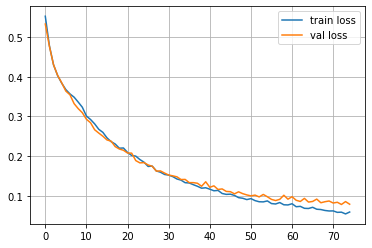

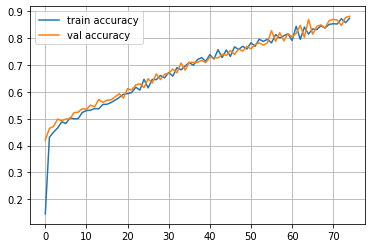

In [8]:
num_classes = Y_train.shape[1]
hidden_size = 100
model = keras.Sequential(
        [
            layers.Dense(hidden_size,
                         input_dim=X_train.shape[1],
                         kernel_initializer='glorot_uniform',
                         activation=tf.nn.relu),
            
            layers.Dropout(0.1),
                        
            layers.Dense(hidden_size,
                         kernel_initializer='glorot_uniform',
                         activation=tf.nn.relu),
            
            layers.Dense(hidden_size,
                         kernel_initializer='glorot_uniform',
                         activation=tf.nn.relu),
            
            
            layers.Dense(num_classes, 
                         kernel_initializer='glorot_uniform', 
                         activation=tf.nn.softmax),
        ]
    )
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, Y_train,
                    batch_size=256, #X_train.shape[0],
                    epochs=75,
                    verbose=False,
                    validation_data=(X_val, Y_val),
                    class_weight=class_weights
                   )

plot_loss(history)
plot_accuracy(history)

## Evaluation on test

In [11]:
conf_matrix = get_confusion_matrix(model, X_test, Y_test)
print(conf_matrix)

# implementation for highlighting main diagonal taken from 
# https://stackoverflow.com/a/56916309
def highlight_diag(df):
    a = numpy.full(df.shape, '', dtype='<U24')
    numpy.fill_diagonal(a, 'background-color: yellow')
    return pd.DataFrame(a, index=df.index, columns=df.columns)

score = model.evaluate(X_test, Y_test, verbose=0)
print('\nTest loss:\t{:.6f}'.format(score[0]))
print('Test accuracy:\t{:.6f}'.format(score[1]))

pd.DataFrame(conf_matrix, columns=researchconcepts, index=researchconcepts).style.apply(highlight_diag, axis=None)

[[1277   35   19    0   95    0   28]
 [   0   87    0    0    1    0    1]
 [   1    1   93    0    4    0    2]
 [   1    0    0   10    0    0    0]
 [   0    0    1    0   22    0    0]
 [   7   11    0    0    8  110   26]
 [   1    3    1    0    7    0  120]]

Test loss:	0.361958
Test accuracy:	0.871704


,664,682,691,693,697,707,710
664,1277,35,19,0,95,0,28
682,0,87,0,0,1,0,1
691,1,1,93,0,4,0,2
693,1,0,0,10,0,0,0
697,0,0,1,0,22,0,0
707,7,11,0,0,8,110,26
710,1,3,1,0,7,0,120


In [15]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, to_categorical( numpy.argmax(model.predict(X_test), axis=1) ),
                           digits=4,
                           target_names=["CWE-"+str(cwe_id) for cwe_id in researchconcepts]) )

              precision    recall  f1-score   support

     CWE-664     0.9922    0.8783    0.9318      1454
     CWE-682     0.6350    0.9775    0.7699        89
     CWE-691     0.8158    0.9208    0.8651       101
     CWE-693     1.0000    0.9091    0.9524        11
     CWE-697     0.1606    0.9565    0.2750        23
     CWE-707     1.0000    0.6790    0.8088       162
     CWE-710     0.6780    0.9091    0.7767       132

   micro avg     0.8717    0.8717    0.8717      1972
   macro avg     0.7545    0.8900    0.7685      1972
weighted avg     0.9370    0.8717    0.8930      1972
 samples avg     0.8717    0.8717    0.8717      1972



In [16]:
savename = 'CWE_MLP_Var1_distinct_word2vec_weightedClasses.h5'
model.save(savename)
#model.load_weights(savename)